In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
nvidia_df = pd.read_csv('./datasets/NVDA.csv')
nvidia_df['Date'] = pd.to_datetime(nvidia_df['Date'])
nvidia_df.set_index('Date', inplace=True)

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(nvidia_df)

In [4]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
target = ['Close']  # Predicting the 'Close' price

In [5]:
def generate_sequences(dataset, length):
    X = np.array([dataset[i:i+length] for i in range(len(dataset) - length)])
    y = np.array([dataset[i+length] for i in range(len(dataset) - length)])
    return X, y

sequence_length = 10
X, y = generate_sequences(scaled_data, sequence_length)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1, activation='relu')
])
model.compile(optimizer='adam', loss='mean_squared_error')

2024-05-06 15:01:29.740944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 15:01:29.741417: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/johnbjohn/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  

In [8]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0804  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


In [9]:
predictions.shape

(48, 1)

In [10]:
y_test_inverse = scaler.inverse_transform(y_test)
original_stock_price = y_test_inverse[:, 3]

In [11]:
temp = y_test.copy()
temp[:, 3] = predictions.reshape(-1)
predicted_stock_price = scaler.inverse_transform(temp)[:, 3]

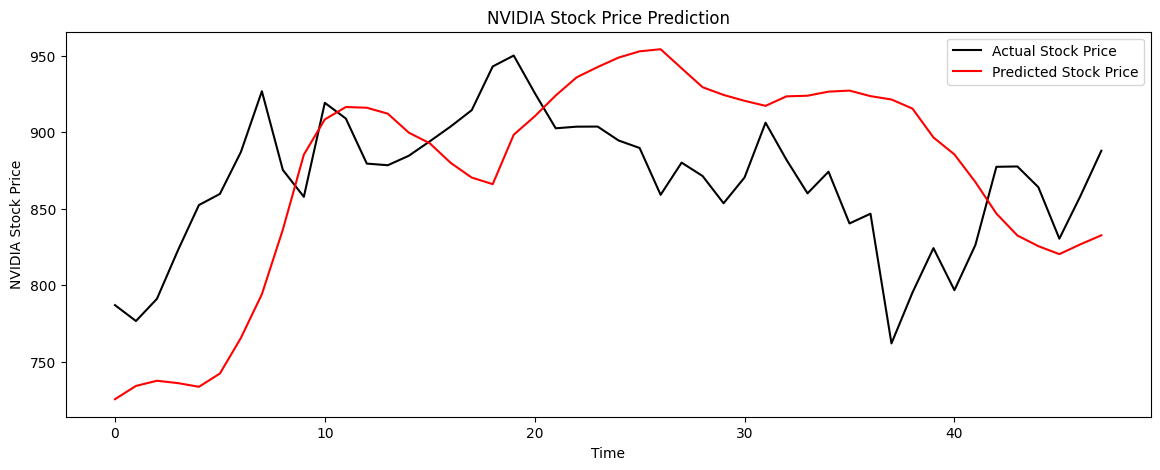

In [16]:
plt.figure(figsize=(14, 5))
plt.plot(original_stock_price, color='black', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVIDIA Stock Price')
plt.legend()
# save plot to file
plt.savefig('nvidia_stock_price_prediction.png')